In [1]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

# Fetch data

In [2]:
from urllib.request import urlretrieve
for i in range(1,7):
    print('downloading.. {}'.format(i))
    if not os.path.exists('./enron{}.tar.gz'.format(i)):
        filename, headers = urlretrieve('http://www.aueb.gr/users/ion/data/enron-spam/preprocessed/enron{}.tar.gz'.format(i), './enron{}.tar.gz'.format(i))

downloading.. 1
downloading.. 2
downloading.. 3
downloading.. 4
downloading.. 5
downloading.. 6


In [3]:
import tarfile
for i in range(1,7):
    print('Uncompressing... {}'.format(i))
    if not os.path.exists('./enron{}'.format(i)):
        filename = tarfile.open('enron{}.tar.gz'.format(i))
        filename.extractall('.'.format(i))
        filename.close()

Uncompressing... 1
Uncompressing... 2
Uncompressing... 3
Uncompressing... 4
Uncompressing... 5
Uncompressing... 6


In [4]:
emails,labels=[],[]
for i in range(1,7):
    spam_path='enron{}/spam/'.format(i)
    for filename in sorted(glob.glob(os.path.join(spam_path,'*.txt'))):
        with open(filename,'r',encoding='ISO-8859-1') as infile:
            emails.append(infile.read())
            labels.append(1)
    ham_path='enron{}/ham/'.format(i)
    for filename in sorted(glob.glob(os.path.join(ham_path,'*.txt'))):
        with open(filename,'r',encoding='ISO-8859-1') as infile:
            emails.append(infile.read())
            labels.append(0)
print('Nonspam (lable=0) : spam (label=1) = {:.2f}%:{:.2f}%'.format(100*(1-sum(labels)/len(labels)),100*(sum(labels)/len(labels))))

Nonspam (lable=0) : spam (label=1) = 49.07%:50.93%


# Preprocessing: clean stop words, lemmatization, and vectorization

In [5]:
from nltk.corpus import names
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
all_name=set(names.words())
lemmatizer=WordNetLemmatizer()

In [6]:
def clean_text(docs):
    '''remove words composed of names, non letter characters. Then lemmatize it.
    
    Parameters
    ----------
    docs: list
        list of original emails
        
    Returns
    -------
    docs_cleaned: list
        list of cleaned emails
    '''
    docs_cleaned=[]
    for doc in docs:
        doc_cleaned= ' '.join(lemmatizer.lemmatize(word) for word in doc.split() if word not in all_name and word.isalpha())
        docs_cleaned.append(doc_cleaned)
    return docs_cleaned

In [7]:
def countvectorizer(X_train,X_test,cv=None,**kwargs):
        '''Vectorize texts by calling `CountVectorizer` from `sklearn`. The dimension is num_samples by num_features.

        Parameters
        -----------
        X_train: list
            Raw texts of training data

        X_test: list
            Raw texts of test data
            
        **kwargs: dict, optional
            Same parameters for CounterVectorizer
            Default:
            stop_words='english'
            max_features=1000
            max_df=0.5
            min_df=2
        '''
        if cv is None:
            kwargs['stop_words']=kwargs.get('stop_words','english')
            kwargs['max_features']=kwargs.get('max_features',1000)
            kwargs['max_df']=kwargs.get('max_df',.5)
            kwargs['min_df']=kwargs.get('min_df',2)
            cv=CountVectorizer(**kwargs)
        
        term_docs_train=cv.fit_transform(X_train)
        term_docs_test=cv.transform(X_test)
        return cv,term_docs_train,term_docs_test

# Naive Bayes

## Construct Bayes model from scratch

In [8]:
class Bayes:
    def __init__(self,X_train_term,y_train,X_test_term,y_test,smoothing=1,threshold=0.5):
        '''Detect spam emails using naive Bayes. The texts of emails are treated uisng bag of words (BOW) model.

        Parameters
        -----------
        X_test_term: list
            Text for training data.
        y_train: list
            Label for training data.
        X_test_term: list, optional
            Text for test data.
        y_test: list, optional
            Label for test data.
        '''
        assert X_train_term.shape[0]==len(y_train), 'Number of samples in training data ({}) does not equal to the number of labesl ({})'.format(X_train_term.shape[0],len(y_train))
        assert X_test_term.shape[0]==len(y_test), 'Number of samples in test data ({}) does not equal to the number of labesl ({})'.format(X_test_term.shape[0],len(y_test))
        self.X_train_term=X_train_term
        self.y_train=y_train
        self.X_test_term=X_test_term
        self.y_test=y_test
        self.label_to_text={0:'NonSpam',1:'Spam'}
        self.smoothing=smoothing
        self.threshold=threshold
        
    def get_label_index(self):
        '''A dictionary containing the indices for each label.

        Returns
        -------
        self.label_index: dict
            A dictionary with labels as keys, and indices as values.
        '''
        self.label_index=defaultdict(list)
        for index, label in enumerate(self.y_train):
            self.label_index[label].append(index)
        return self.label_index

    def get_prior(self):
        '''Calculate the prior probability, P(label).

        Returns
        -------
        self.prior: dict
            A dictionary of the prior probability for each label
        '''
        self.prior={key:len(self.label_index[key])/len(self.y_train) for key in self.label_index.keys()}
        return self.prior
        
    def get_likelihood(self,smoothing=0):
        '''Calculate the likelihood from the training data for each label, P(x|label).

        Parameters
        ----------
        smoothing: int
            Apply an additional smoothing to the probability to avoid exact zero. P=(occurrence+smoothing)/(Normalization factor)
        
        Returns
        -------
        self.likelihood: dict
            The likelihood of each feature conditioned on each label. The value of dict is a dense 1d array with length of num_features.        
        '''
        self.likelihood={}
        for label, index in self.label_index.items():
            self.likelihood[label]=self.X_train_term[index].sum(axis=0)+smoothing
            self.likelihood[label]=self.likelihood[label]/self.likelihood[label].sum()
            self.likelihood[label]=np.asarray(self.likelihood[label]).flatten()
        return self.likelihood
    
    def get_posterior(self):
        '''Calculate the posterior probability of each label for test data. In order to avoid the multiplication of many small value conditional probability (likelihood), we calculate the summation of their log, followed by exponantiating them.
        
        Returns
        -------
        self.posterior: pandas dataframe
            The posterior probability of test data. The rows are for each sample, and the columns are for each label.
        '''
        assert hasattr(self, 'X_test_term'), 'Missing test data'
        likelihood_mat=[]
        prior_mat=[]
        for key in self.likelihood.keys():
            likelihood_mat.append(self.likelihood[key])
            prior_mat.append(self.prior[key])

        likelihood_mat=np.array(likelihood_mat).T   # num_features by num_labels
        prior_mat=np.array(prior_mat)   # 1 by num_labels
        log_posterior=self.X_test_term@np.log(likelihood_mat)+np.log(prior_mat)
        log_posterior=log_posterior-log_posterior.max(axis=1,keepdims=True)
        exp_log_posterior=np.exp(log_posterior)
        posterior=exp_log_posterior/exp_log_posterior.sum(axis=1,keepdims=True)
        self.posterior=pd.DataFrame(posterior,columns=[self.label_to_text[key] for key in self.likelihood.keys()])
        return self.posterior
    
    def predict(self):
        '''Predict the outcome of whether it is Spam based on whether the probability is larger than the `self.threshold`

        Returns
        -------
        self.prediction:
            The prediction of whether it is Spam (1) or NonSpam (0).
        '''
        self.prediction=(self.posterior['Spam']>self.threshold)*1
        return self.prediction

    def fit(self):
        '''Fit Naive Bayes model
        '''
        self.get_label_index()
        self.get_prior()
        self.get_likelihood(smoothing=self.smoothing)
        self.get_posterior()
        self.predict()

###  Split training and test data

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
emails_clean=clean_text(emails)

In [11]:
X_train,X_test,y_train,y_test=train_test_split(emails_clean,labels,test_size=0.33,random_state=42)

In [12]:
len(y_train),len(y_test)

(22589, 11127)

In [13]:
cv,X_train_term,X_test_term=countvectorizer(X_train,X_test)

In [14]:
bayes=Bayes(X_train_term,y_train,X_test_term,y_test)
bayes.fit()

### Metrics: confusion matrix, accuracy, precision, recall, F1 score, AUC of ROC

In [15]:
import sklearn.metrics

In [16]:
sklearn.metrics.confusion_matrix(y_test,bayes.prediction,labels=[0,1])

array([[5283,  241],
       [ 164, 5439]])

In [17]:
print(sklearn.metrics.classification_report(y_test,bayes.prediction))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      5524
           1       0.96      0.97      0.96      5603

    accuracy                           0.96     11127
   macro avg       0.96      0.96      0.96     11127
weighted avg       0.96      0.96      0.96     11127



In [18]:
FP_list,TP_list,threshold_list=sklearn.metrics.roc_curve(y_test,bayes.posterior.Spam,pos_label=1)

Text(0.5, 1.0, 'AUC of ROC=0.98677')

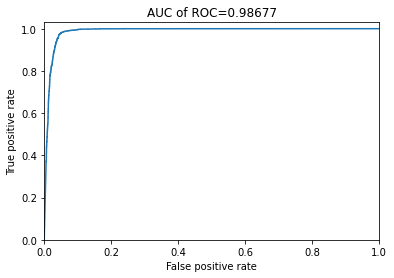

In [19]:
fig,ax=plt.subplots()
ax.plot(FP_list,TP_list)
ax.set_xlim([0,1])
ax.set_ylim([0,1.03])
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('AUC of ROC={:.5f}'.format(np.diff(FP_list)@(TP_list[1:]+TP_list[:-1])/2))

In [20]:
print('AUC of ROC is {:f}'.format(sklearn.metrics.roc_auc_score(y_test,bayes.posterior.Spam)))

AUC of ROC is 0.986771


### Cross validation to fine-tune parameters

#### Coarse search

In [21]:
from sklearn.model_selection import StratifiedKFold
k = 5
# k_fold = StratifiedKFold(n_splits=k)
k_fold = StratifiedKFold(n_splits=k,shuffle=True,random_state=42)

In [22]:
max_features_option_bayes=[500,2000,None]
smoothing_factor_option_bayes=[.5,1,2]

In [23]:
from itertools import product
def cross_validation(*args):
    '''Calculate the AUC of ROC using cross validation. The parameter to be tuned are the cartesian product of them.

    Parameters
    ----------
    args: variable number of lists
        The list to be tuned.

    Returns
    -------
    bayes_dict: dict
        The dictionary for the Bayes models.
    
    auc_dict: dict
        The dictionary for the AUC of each CV fold.

    auc_mean_dict: dict
        The dictionary for the mean AUC.
    
    acc_dict: dict
        The dictionary for accuracy for each CV fold
    
    acc_mean_dict: dict
        The dictionary for accuracy for the mean accuracy 
    '''
    i=0
    auc_dict=defaultdict(list)
    acc_dict=defaultdict(list)
    bayes_dict=defaultdict(list)
    for train_index,test_index in k_fold.split(emails_clean,labels):
        print('CV {} Fold'.format(i))
        for iteration in product(*args):
            max_features,smoothing=iteration
            _,X_train_term_cv,X_test_term_cv=countvectorizer([emails_clean[i] for i in train_index],[emails_clean[i] for i in test_index],max_features=max_features)
            y_train_cv=[labels[i] for i in train_index]
            y_test_cv=[labels[i] for i in test_index]
            bayes_dict[iteration].append(Bayes(X_train_term_cv,y_train_cv,X_test_term_cv,y_test_cv,smoothing=smoothing))
            bayes_dict[iteration][i].fit()
            auc_dict[iteration].append(sklearn.metrics.roc_auc_score(y_test_cv,bayes_dict[iteration][i].posterior.Spam))
            acc_dict[iteration].append(sklearn.metrics.accuracy_score(y_test_cv,bayes_dict[iteration][i].prediction))
        i+=1
    
    auc_mean_dict={}
    for iteration in product(*args):
        auc_mean_dict[iteration]=np.mean(auc_dict[iteration])
        
    acc_mean_dict={}
    for iteration in product(*args):
        acc_mean_dict[iteration]=np.mean(acc_dict[iteration])
    return bayes_dict,auc_dict, auc_mean_dict, acc_dict, acc_mean_dict


In [24]:
bayes_dict_bayes,auc_dict_bayes, auc_mean_dict_bayes, acc_dict_bayes, acc_mean_dict_bayes=cross_validation(max_features_option_bayes,smoothing_factor_option_bayes)

CV 0 Fold
CV 1 Fold
CV 2 Fold
CV 3 Fold
CV 4 Fold


In [25]:
pd.DataFrame({'Params(max_features,smoothing)':list(auc_mean_dict_bayes.keys()),'AUC_ROC':list(auc_mean_dict_bayes.values()),'accuracy':list(list(acc_mean_dict_bayes.values()))}).sort_values('AUC_ROC',ascending=False).set_index('AUC_ROC').rename_axis('Sorted by AUC')

Params(max_features,smoothing)  accuracy
Sorted by AUC                                         
0.996797                         (None, 0.5)  0.986979
0.996684                           (None, 1)  0.986446
0.996584                           (None, 2)  0.986001
0.990802                         (2000, 0.5)  0.971468
0.990688                           (2000, 1)  0.971379
0.990555                           (2000, 2)  0.971171
0.977814                          (500, 0.5)  0.948333
0.977652                            (500, 1)  0.948274
0.977440                            (500, 2)  0.948066

In [26]:
pd.DataFrame({'Params(max_features,smoothing)':list(auc_mean_dict_bayes.keys()),'AUC_ROC':list(auc_mean_dict_bayes.values()),'accuracy':list(list(acc_mean_dict_bayes.values()))}).sort_values('accuracy',ascending=False).set_index('accuracy').rename_axis('Sorted by accuracy')

Params(max_features,smoothing)   AUC_ROC
Sorted by accuracy                                         
0.986979                              (None, 0.5)  0.996797
0.986446                                (None, 1)  0.996684
0.986001                                (None, 2)  0.996584
0.971468                              (2000, 0.5)  0.990802
0.971379                                (2000, 1)  0.990688
0.971171                                (2000, 2)  0.990555
0.948333                               (500, 0.5)  0.977814
0.948274                                 (500, 1)  0.977652
0.948066                                 (500, 2)  0.977440

>**A coarse search indicates that `max_features=None` and small smoothing generally perform better, which neccesitates a fine search on the optimal smoothing factor.**

#### fine search

In [27]:
max_features_option_bayes_fine=[None,]
smoothing_factor_option_bayes_fine=10**np.arange(-3,1,0.5)

In [28]:
bayes_dict_bayes_fine,auc_dict_bayes_fine, auc_mean_dict_bayes_fine, acc_dict_bayes_fine, acc_mean_dict_bayes_fine =cross_validation(max_features_option_bayes_fine,smoothing_factor_option_bayes_fine)

CV 0 Fold
CV 1 Fold
CV 2 Fold
CV 3 Fold
CV 4 Fold


In [30]:
pd.DataFrame({'Params(max_features,smoothing)':list(auc_mean_dict_bayes_fine.keys()),'AUC_ROC':list(auc_mean_dict_bayes_fine.values()),'accuracy':list(list(acc_mean_dict_bayes_fine.values()))}).sort_values('AUC_ROC',ascending=False).set_index('AUC_ROC').rename_axis('Sorted by AUC')

Params(max_features,smoothing)  accuracy
Sorted by AUC                                         
0.997092                        (None, 0.01)  0.987276
0.997074         (None, 0.03162277660168379)  0.987276
0.997025       (None, 0.0031622776601683794)  0.987187
0.996986                         (None, 0.1)  0.987187
0.996914                       (None, 0.001)  0.987098
0.996878         (None, 0.31622776601683794)  0.987098
0.996684                         (None, 1.0)  0.986446
0.996467          (None, 3.1622776601683795)  0.985319

In [31]:
pd.DataFrame({'Params(max_features,smoothing)':list(auc_mean_dict_bayes_fine.keys()),'AUC_ROC':list(auc_mean_dict_bayes_fine.values()),'accuracy':list(list(acc_mean_dict_bayes_fine.values()))}).sort_values('accuracy',ascending=False).set_index('accuracy').rename_axis('Sorted by accuracy')

Params(max_features,smoothing)   AUC_ROC
Sorted by accuracy                                         
0.987276                             (None, 0.01)  0.997092
0.987276              (None, 0.03162277660168379)  0.997074
0.987187            (None, 0.0031622776601683794)  0.997025
0.987187                              (None, 0.1)  0.996986
0.987098                            (None, 0.001)  0.996914
0.987098              (None, 0.31622776601683794)  0.996878
0.986446                              (None, 1.0)  0.996684
0.985319               (None, 3.1622776601683795)  0.996467

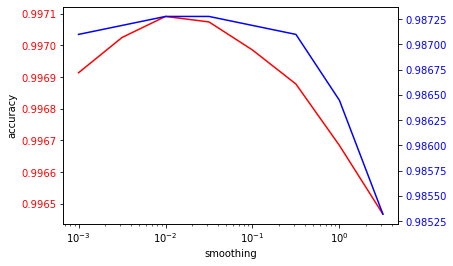

In [32]:
fig,ax=plt.subplots()
ax.plot(smoothing_factor_option_bayes_fine,[auc_mean_dict_bayes_fine[(None,i)] for i in smoothing_factor_option_bayes_fine],'r')
ax1=ax.twinx()
ax1.plot(smoothing_factor_option_bayes_fine,[acc_mean_dict_bayes_fine[(None,i)] for i in smoothing_factor_option_bayes_fine],'b')

ax.set_xlabel('smoothing')
ax.set_ylabel('ROC_AUC')
ax.set_ylabel('accuracy')
ax.tick_params(axis='y', labelcolor='r')
ax1.tick_params(axis='y', labelcolor='b')
ax.set_xscale('log')

>**The optimal parameter is chosen at `max_features=None` and `smoothing=0.01` in the naive Bayes model.**

In [33]:
best_auc_bayes,best_acc_bayes=auc_mean_dict_bayes_fine[(None,0.01)],acc_mean_dict_bayes_fine[(None,0.01)]
print('Best esimate of ROC_AUC: {:.4f}'.format(best_auc_bayes))
print('Best esimate of accuracy: {:.4f}'.format(best_acc_bayes))

Best esimate of ROC_AUC: 0.9971
Best esimate of accuracy: 0.9873


## Sklearn `MultinomialNB`

### Split training and test data

In [34]:
from sklearn.naive_bayes import MultinomialNB

In [35]:
X_train,X_test,y_train,y_test=train_test_split(emails_clean,labels,test_size=0.33,random_state=42)

In [36]:
cv,X_train_term,X_test_term=countvectorizer(X_train,X_test)

In [37]:
clf=MultinomialNB(alpha=1,fit_prior=True)

In [38]:
clf.fit(X_train_term,y_train)

MultinomialNB(alpha=1)

### Metrics: confusion matrix, accuracy, precision, recall, F1 score, AUC of ROC

In [39]:
y_test_pred=clf.predict(X_test_term)

In [40]:
clf.score(X_test_term,y_test)

0.9636020490698302

In [41]:
sklearn.metrics.confusion_matrix(y_test,clf.predict(X_test_term),labels=[0,1])

array([[5283,  241],
       [ 164, 5439]])

In [42]:
print(sklearn.metrics.classification_report(y_test,clf.predict(X_test_term)))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      5524
           1       0.96      0.97      0.96      5603

    accuracy                           0.96     11127
   macro avg       0.96      0.96      0.96     11127
weighted avg       0.96      0.96      0.96     11127



In [43]:
FP_list_bayes_sk,TP_list_bayes_sk,threshold_list_bayes_sk=sklearn.metrics.roc_curve(y_test,clf.predict_proba(X_test_term)[:,1],pos_label=1)

Text(0.5, 1.0, 'AUC of ROC=0.98680')

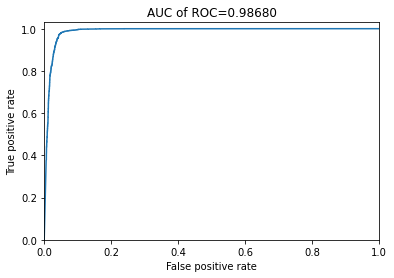

In [44]:
fig,ax=plt.subplots()
ax.plot(FP_list_bayes_sk,TP_list_bayes_sk)
ax.set_xlim([0,1])
ax.set_ylim([0,1.03])
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('AUC of ROC={:.5f}'.format(np.diff(FP_list_bayes_sk)@(TP_list_bayes_sk[1:]+TP_list_bayes_sk[:-1])/2))

In [45]:
print('AUC of ROC is {:f}'.format(sklearn.metrics.roc_auc_score(y_test,clf.predict_proba(X_test_term)[:,1])))

AUC of ROC is 0.986797


>**The results are the same as the Bayes model from scratch.**

### Cross validation to fine-tune parameters

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#### Coarse search

In [47]:
max_features_option_bayes_sk=[500,2000,None]
smoothing_factor_option_bayes_sk=[.5,1,2]

In [48]:
pipeline_bayes_sk=Pipeline([('cv',CountVectorizer(stop_words='english',max_df=0.5,min_df=2)),('clf',MultinomialNB(fit_prior=True))])
parameters_pipeline_bayes_sk={'cv__max_features':max_features_option_bayes_sk,'clf__alpha':smoothing_factor_option_bayes_sk}

In [49]:
grid_search_bayes_sk=GridSearchCV(pipeline_bayes_sk,parameters_pipeline_bayes_sk,n_jobs=-1,cv=k_fold,verbose=1,scoring=['roc_auc','accuracy'],refit=False)
grid_search_bayes_sk.fit(emails_clean,labels)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(max_df=0.5, min_df=2,
                                                        stop_words='english')),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.5, 1, 2],
                         'cv__max_features': [500, 2000, None]},
             refit=False, scoring=['roc_auc', 'accuracy'], verbose=1)

In [50]:
cv_results_df_bayes_sk=pd.DataFrame(grid_search_bayes_sk.cv_results_)

In [51]:
cv_results_df_bayes_sk.sort_values('mean_test_roc_auc',ascending=False).loc[:,['params','mean_test_roc_auc','mean_test_accuracy']].set_index('mean_test_roc_auc').rename_axis('Sorted by AUC')

params  \
Sorted by AUC                                                  
0.996842       {'clf__alpha': 0.5, 'cv__max_features': None}   
0.996689         {'clf__alpha': 1, 'cv__max_features': None}   
0.996519         {'clf__alpha': 2, 'cv__max_features': None}   
0.990749       {'clf__alpha': 0.5, 'cv__max_features': 2000}   
0.990638         {'clf__alpha': 1, 'cv__max_features': 2000}   
0.990487         {'clf__alpha': 2, 'cv__max_features': 2000}   
0.977768        {'clf__alpha': 0.5, 'cv__max_features': 500}   
0.977615          {'clf__alpha': 1, 'cv__max_features': 500}   
0.977399          {'clf__alpha': 2, 'cv__max_features': 500}   

               mean_test_accuracy  
Sorted by AUC                      
0.996842                 0.986979  
0.996689                 0.986446  
0.996519                 0.986001  
0.990749                 0.971468  
0.990638                 0.971379  
0.990487                 0.971171  
0.977768                 0.948333  
0.977615                 0.948274  
0.977399                 0.948066

In [52]:
cv_results_df_bayes_sk.sort_values('mean_test_accuracy',ascending=False).loc[:,['params','mean_test_roc_auc','mean_test_accuracy']].set_index('mean_test_accuracy').rename_axis('Sorted by').rename_axis('Sorted by accuracy')

params  \
Sorted by accuracy                                                  
0.986979            {'clf__alpha': 0.5, 'cv__max_features': None}   
0.986446              {'clf__alpha': 1, 'cv__max_features': None}   
0.986001              {'clf__alpha': 2, 'cv__max_features': None}   
0.971468            {'clf__alpha': 0.5, 'cv__max_features': 2000}   
0.971379              {'clf__alpha': 1, 'cv__max_features': 2000}   
0.971171              {'clf__alpha': 2, 'cv__max_features': 2000}   
0.948333             {'clf__alpha': 0.5, 'cv__max_features': 500}   
0.948274               {'clf__alpha': 1, 'cv__max_features': 500}   
0.948066               {'clf__alpha': 2, 'cv__max_features': 500}   

                    mean_test_roc_auc  
Sorted by accuracy                     
0.986979                     0.996842  
0.986446                     0.996689  
0.986001                     0.996519  
0.971468                     0.990749  
0.971379                     0.990638  
0.971171                     0.990487  
0.948333                     0.977768  
0.948274                     0.977615  
0.948066                     0.977399

>**`max_features=None` generally performs better. The next steps is to fine-tune the `smoothing` factor given `max_features=None`.**

#### Fine search

In [53]:
smoothing_factor_option_bayes_sk_fine=10**np.arange(-3,1,0.5)
parameters_pipeline_bayes_sk={'clf__alpha':smoothing_factor_option_bayes_sk_fine}

In [54]:
grid_search_bayes_sk_fine=GridSearchCV(pipeline_bayes_sk,parameters_pipeline_bayes_sk,n_jobs=-1,cv=k_fold,verbose=1,scoring=['roc_auc','accuracy'],refit=False)

In [55]:
grid_search_bayes_sk_fine.fit(emails_clean,labels)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(max_df=0.5, min_df=2,
                                                        stop_words='english')),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00])},
             refit=False, scoring=['roc_auc', 'accuracy'], verbose=1)

In [56]:
cv_results_df_bayes_sk_fine=pd.DataFrame(grid_search_bayes_sk_fine.cv_results_)

In [57]:
cv_results_df_bayes_sk_fine

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       3.278318      0.219942         2.371848        0.348507   
1       4.211076      0.185294         2.649143        0.100262   
2       4.790254      0.431222         2.432700        0.187875   
3       5.156910      0.560414         2.332056        0.335088   
4       5.616891      0.126990         2.132576        0.207193   
5       5.520371      0.193316         1.794696        0.255288   
6       5.251322      0.175823         1.615208        0.101760   
7       4.225534      0.435460         1.460322        0.091339   

  param_clf__alpha                                 params  \
0            0.001                  {'clf__alpha': 0.001}   
1         0.003162  {'clf__alpha': 0.0031622776601683794}   
2             0.01                   {'clf__alpha': 0.01}   
3         0.031623    {'clf__alpha': 0.03162277660168379}   
4              0.1                    {'clf__alpha': 0.1}   
5         0.316228    {'clf__alpha': 0.31622776601683794}   
6              1.0                    {'clf__alpha': 1.0}   
7         3.162278     {'clf__alpha': 3.1622776601683795}   

   split0_test_roc_auc  split1_test_roc_auc  split2_test_roc_auc  \
0             0.995214             0.997271             0.996849   
1             0.995209             0.997478             0.997071   
2             0.995412             0.997379             0.997022   
3             0.995847             0.997046             0.996962   
4             0.995841             0.996547             0.996858   
5             0.995901             0.996499             0.996829   
6             0.995798             0.996272             0.996662   
7             0.995517             0.995961             0.996413   

   split3_test_roc_auc  ...  std_test_roc_auc  rank_test_roc_auc  \
0             0.997197  ...          0.000799                  6   
1             0.997202  ...          0.000837                  5   
2             0.997618  ...          0.000795                  2   
3             0.997643  ...          0.000647                  1   
4             0.997894  ...          0.000708                  3   
5             0.997828  ...          0.000666                  4   
6             0.997361  ...          0.000610                  7   
7             0.996971  ...          0.000613                  8   

   split0_test_accuracy  split1_test_accuracy  split2_test_accuracy  \
0              0.985320              0.985318              0.987543   
1              0.986210              0.984873              0.987543   
2              0.986358              0.985022              0.987543   
3              0.986655              0.984428              0.987543   
4              0.986803              0.984577              0.987394   
5              0.986951              0.983687              0.987394   
6              0.985913              0.983538              0.986505   
7              0.984579              0.982055              0.985318   

   split3_test_accuracy  split4_test_accuracy  mean_test_accuracy  \
0              0.988284              0.989026            0.987098   
1              0.988284              0.989026            0.987187   
2              0.988581              0.988877            0.987276   
3              0.988877              0.988877            0.987276   
4              0.988284              0.988877            0.987187   
5              0.988877              0.988581            0.987098   
6              0.988284              0.987988            0.986446   
7              0.986801              0.987839            0.985319   

   std_test_accuracy  rank_test_accuracy  
0           0.001526                   5  
1           0.001485                   3  
2           0.001433                   1  
3           0.001655                   2  
4           0.001488                   4  
5           0.001850                   6  
6           0.001703                   7  
7           0.001

In [58]:
cv_results_df_bayes_sk_fine.sort_values('mean_test_roc_auc',ascending=False).loc[:,['params','mean_test_roc_auc','mean_test_accuracy']].set_index('mean_test_roc_auc').rename_axis('Sorted by AUC')

params  mean_test_accuracy
Sorted by AUC                                                           
0.997017         {'clf__alpha': 0.03162277660168379}            0.987276
0.996957                        {'clf__alpha': 0.01}            0.987276
0.996912                         {'clf__alpha': 0.1}            0.987187
0.996880         {'clf__alpha': 0.31622776601683794}            0.987098
0.996862       {'clf__alpha': 0.0031622776601683794}            0.987187
0.996775                       {'clf__alpha': 0.001}            0.987098
0.996689                         {'clf__alpha': 1.0}            0.986446
0.996405          {'clf__alpha': 3.1622776601683795}            0.985319

In [59]:
cv_results_df_bayes_sk_fine.sort_values('mean_test_accuracy',ascending=False).loc[:,['params','mean_test_roc_auc','mean_test_accuracy']].set_index('mean_test_accuracy').rename_axis('Sorted by accuracy')

params  mean_test_roc_auc
Sorted by accuracy                                                          
0.987276                             {'clf__alpha': 0.01}           0.996957
0.987276              {'clf__alpha': 0.03162277660168379}           0.997017
0.987187            {'clf__alpha': 0.0031622776601683794}           0.996862
0.987187                              {'clf__alpha': 0.1}           0.996912
0.987098                            {'clf__alpha': 0.001}           0.996775
0.987098              {'clf__alpha': 0.31622776601683794}           0.996880
0.986446                              {'clf__alpha': 1.0}           0.996689
0.985319               {'clf__alpha': 3.1622776601683795}           0.996405

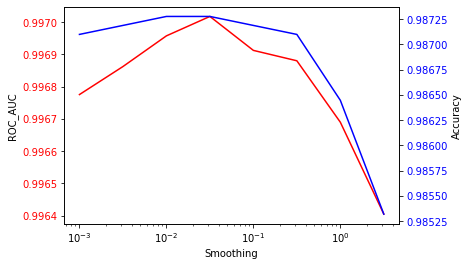

In [60]:
fig,ax=plt.subplots()
ax.plot(cv_results_df_bayes_sk_fine['param_clf__alpha'],cv_results_df_bayes_sk_fine['mean_test_roc_auc'],'r')
ax1=ax.twinx()
ax1.plot(cv_results_df_bayes_sk_fine['param_clf__alpha'],cv_results_df_bayes_sk_fine['mean_test_accuracy'],'b')
ax.set_ylabel('ROC_AUC')
ax1.set_ylabel('Accuracy')
ax.set_xlabel('Smoothing')
ax.tick_params(axis='y', labelcolor='r')
ax1.tick_params(axis='y', labelcolor='b')
ax.set_xscale('log')

>**The optimal parameter is chosen at `max_features=None` and smoothing `alpha=0.01` in the naive Bayes model.**

In [61]:
best_auc_bayes_sk,best_acc_bayes_sk=cv_results_df_bayes_sk_fine['mean_test_roc_auc'].iloc[2],cv_results_df_bayes_sk_fine['mean_test_accuracy'].iloc[2]
print('Best esimate of ROC_AUC: {:.4f}'.format(best_auc_bayes_sk))
print('Best esimate of accuracy: {:.4f}'.format(best_acc_bayes_sk))

Best esimate of ROC_AUC: 0.9970
Best esimate of accuracy: 0.9873


# SVM

## Sklearn `SVC` and `LinearSVC`

In [62]:
from sklearn.svm import SVC 

In [63]:
X_train,X_test,y_train,y_test=train_test_split(emails_clean,labels,test_size=0.33,random_state=42)

In [64]:
cv,X_train_term,X_test_term=countvectorizer(X_train,X_test)

In [65]:
svm=SVC(kernel='rbf',C=1,random_state=42,probability=True)

In [66]:
svm.fit(X_train_term,y_train)

SVC(C=1, probability=True, random_state=42)

In [67]:
svm.score(X_test_term,y_test)

0.954884515143345

In [68]:
svm.score(X_test_term,y_test)

0.954884515143345

In [69]:
sklearn.metrics.confusion_matrix(y_test,svm.predict(X_test_term),labels=[0,1])

array([[5061,  463],
       [  39, 5564]])

In [70]:
print(sklearn.metrics.classification_report(y_test,svm.predict(X_test_term)))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      5524
           1       0.92      0.99      0.96      5603

    accuracy                           0.95     11127
   macro avg       0.96      0.95      0.95     11127
weighted avg       0.96      0.95      0.95     11127



In [71]:
FP_list_svm_sk,TP_list_svm_sk,threshold_list_svm_sk=sklearn.metrics.roc_curve(y_test,svm.predict_proba(X_test_term)[:,1])

Text(0.5, 1.0, 'AUC of ROC=0.99454')

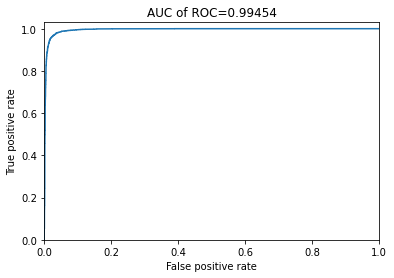

In [72]:
fig,ax=plt.subplots()
ax.plot(FP_list_svm_sk,TP_list_svm_sk)
ax.set_xlim([0,1])
ax.set_ylim([0,1.03])
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('AUC of ROC={:.5f}'.format(np.diff(FP_list_svm_sk)@(TP_list_svm_sk[1:]+TP_list_svm_sk[:-1])/2))

In [73]:
print('AUC of ROC is {:f}'.format(sklearn.metrics.roc_auc_score(y_test,svm.predict_proba(X_test_term)[:,1])))

AUC of ROC is 0.994542


### Cross validation to fine tune parameters

#### Kernel selection

In [75]:
kernel_option_svm_sk=['linear','rbf']
C_option_svm_sk=[.5,1,2]

In [76]:
pipeline_svm_sk=Pipeline([('cv',CountVectorizer(stop_words='english',max_df=0.5,min_df=2)),('svm',SVC())])
parameters_pipeline_svm_sk={'svm__kernel':kernel_option_svm_sk,'svm__C':C_option_svm_sk}

In [77]:
grid_search_svm_sk=GridSearchCV(pipeline_svm_sk,parameters_pipeline_svm_sk,n_jobs=-1,cv=k_fold,verbose=3,scoring=['roc_auc','accuracy'],refit=False)

In [78]:
grid_search_svm_sk.fit(emails_clean,labels)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END svm__C=2, svm__kernel=linear; accuracy: (test=0.979) roc_auc: (test=0.995) total time= 1.1min
[CV 2/5] END svm__C=1, svm__kernel=linear; accuracy: (test=0.982) roc_auc: (test=0.996) total time= 1.1min
[CV 1/5] END svm__C=1, svm__kernel=linear; accuracy: (test=0.981) roc_auc: (test=0.996) total time= 1.1min
[CV 5/5] END svm__C=2, svm__kernel=linear; accuracy: (test=0.982) roc_auc: (test=0.996) total time= 1.1min
[CV 3/5] END svm__C=2, svm__kernel=linear; accuracy: (test=0.980) roc_auc: (test=0.995) total time= 1.1min
[CV 5/5] END svm__C=1, svm__kernel=linear; accuracy: (test=0.983) roc_auc: (test=0.997) total time= 1.1min
[CV 2/5] END svm__C=2, svm__kernel=linear; accuracy: (test=0.980) roc_auc: (test=0.996) total time= 1.1min
[CV 3/5] END svm__C=1, svm__kernel=linear; accuracy: (test=0.982) roc_auc: (test=0.996) total time= 1.2min
[CV 1/5] END svm__C=0.5, svm__kernel=linear; accuracy: (test=0.983) roc_auc: (test=0

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(max_df=0.5, min_df=2,
                                                        stop_words='english')),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'svm__C': [0.5, 1, 2],
                         'svm__kernel': ['linear', 'rbf']},
             refit=False, scoring=['roc_auc', 'accuracy'], verbose=3)

In [79]:
cv_results_df_svm_sk=pd.DataFrame(grid_search_svm_sk.cv_results_)

In [80]:
cv_results_df_svm_sk.sort_values('mean_test_roc_auc',ascending=False).loc[:,['params','mean_test_roc_auc','mean_test_accuracy']].set_index('mean_test_roc_auc').rename_axis('Sorted by AUC')

params  mean_test_accuracy
Sorted by AUC                                                              
0.997524            {'svm__C': 2, 'svm__kernel': 'rbf'}            0.973603
0.996979            {'svm__C': 1, 'svm__kernel': 'rbf'}            0.966841
0.996704       {'svm__C': 0.5, 'svm__kernel': 'linear'}            0.983865
0.996175         {'svm__C': 1, 'svm__kernel': 'linear'}            0.982145
0.996032          {'svm__C': 0.5, 'svm__kernel': 'rbf'}            0.957646
0.995794         {'svm__C': 2, 'svm__kernel': 'linear'}            0.980276

In [81]:
cv_results_df_svm_sk.sort_values('mean_test_accuracy',ascending=False).loc[:,['params','mean_test_roc_auc','mean_test_accuracy']].set_index('mean_test_accuracy').rename_axis('Sorted by accuracy')

params  \
Sorted by accuracy                                             
0.983865            {'svm__C': 0.5, 'svm__kernel': 'linear'}   
0.982145              {'svm__C': 1, 'svm__kernel': 'linear'}   
0.980276              {'svm__C': 2, 'svm__kernel': 'linear'}   
0.973603                 {'svm__C': 2, 'svm__kernel': 'rbf'}   
0.966841                 {'svm__C': 1, 'svm__kernel': 'rbf'}   
0.957646               {'svm__C': 0.5, 'svm__kernel': 'rbf'}   

                    mean_test_roc_auc  
Sorted by accuracy                     
0.983865                     0.996704  
0.982145                     0.996175  
0.980276                     0.995794  
0.973603                     0.997524  
0.966841                     0.996979  
0.957646                     0.996032

>**The linear kernel has better performance over Gaussian kernel because it has a signficant higher average accuracy while with a similar AUC. Furthermore, we can change `SVC` to `LinearSVC` for better performance.**

#### Coarse search: `max_features`, regularization and `C`

In [82]:
from sklearn.svm import LinearSVC

In [83]:
max_features_option_svm_sk_coarse=[500,2000,None]
C_option_svm_sk_coarse=[.5,1,2]
penalty_option_svm_sk_coarse=['l1','l2']
pipeline_svm_sk_coarse=Pipeline([('cv',CountVectorizer(stop_words='english',max_df=0.5,min_df=2)),('svm',LinearSVC(max_iter=100000,loss='squared_hinge',dual=False))])
parameters_pipeline_svm_sk_coarse={'cv__max_features':max_features_option_svm_sk_coarse,'svm__C':C_option_svm_sk,'svm__penalty':penalty_option_svm_sk_coarse}

In [84]:
grid_search_svm_sk_coarse=GridSearchCV(pipeline_svm_sk_coarse,parameters_pipeline_svm_sk_coarse,n_jobs=-1,cv=k_fold,verbose=3,scoring=['roc_auc','accuracy'],refit=False)

In [85]:
grid_search_svm_sk_coarse.fit(emails_clean,labels)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 3/5] END cv__max_features=500, svm__C=0.5, svm__penalty=l2; accuracy: (test=0.968) roc_auc: (test=0.993) total time=   8.8s
[CV 4/5] END cv__max_features=500, svm__C=0.5, svm__penalty=l2; accuracy: (test=0.970) roc_auc: (test=0.994) total time=   9.5s
[CV 1/5] END cv__max_features=500, svm__C=0.5, svm__penalty=l1; accuracy: (test=0.969) roc_auc: (test=0.993) total time=  10.8s
[CV 3/5] END cv__max_features=500, svm__C=0.5, svm__penalty=l1; accuracy: (test=0.968) roc_auc: (test=0.993) total time=  12.4s
[CV 5/5] END cv__max_features=500, svm__C=1, svm__penalty=l2; accuracy: (test=0.969) roc_auc: (test=0.994) total time=  10.2s
[CV 5/5] END cv__max_features=500, svm__C=0.5, svm__penalty=l2; accuracy: (test=0.970) roc_auc: (test=0.994) total time=  11.8s
[CV 4/5] END cv__max_features=500, svm__C=0.5, svm__penalty=l1; accuracy: (test=0.968) roc_auc: (test=0.994) total time=  12.8s
[CV 2/5] END cv__max_features=500, svm__C=0.5

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(max_df=0.5, min_df=2,
                                                        stop_words='english')),
                                       ('svm',
                                        LinearSVC(dual=False,
                                                  max_iter=100000))]),
             n_jobs=-1,
             param_grid={'cv__max_features': [500, 2000, None],
                         'svm__C': [0.5, 1, 2], 'svm__penalty': ['l1', 'l2']},
             refit=False, scoring=['roc_auc', 'accuracy'], verbose=3)

In [86]:
cv_results_df_svm_sk_coarse=pd.DataFrame(grid_search_svm_sk_coarse.cv_results_)

In [87]:
cv_results_df_svm_sk_coarse.sort_values('mean_test_roc_auc',ascending=False).loc[:,['param_cv__max_features', 'param_svm__C', 'param_svm__penalty','mean_test_roc_auc','mean_test_accuracy']].set_index('mean_test_roc_auc').rename_axis('Sorted by AUC')

param_cv__max_features param_svm__C param_svm__penalty  \
Sorted by AUC                                                          
0.997123                        None          0.5                 l2   
0.996995                        None            1                 l2   
0.996922                        None          0.5                 l1   
0.996875                        None            2                 l2   
0.996644                        None            1                 l1   
0.996486                        2000          0.5                 l1   
0.996451                        None            2                 l1   
0.996226                        2000          0.5                 l2   
0.995972                        2000            1                 l1   
0.995918                        2000            1                 l2   
0.995684                        2000            2                 l2   
0.995395                        2000            2                 l1   
0.993556                         500          0.5                 l1   
0.993496                         500            1                 l1   
0.993454                         500            2                 l1   
0.993440                         500            1                 l2   
0.993426                         500            2                 l2   
0.993424                         500          0.5                 l2   

               mean_test_accuracy  
Sorted by AUC                      
0.997123                 0.985971  
0.996995                 0.985408  
0.996922                 0.983658  
0.996875                 0.985408  
0.996644                 0.982827  
0.996486                 0.981492  
0.996451                 0.982323  
0.996226                 0.982501  
0.995972                 0.980573  
0.995918                 0.981908  
0.995684                 0.981226  
0.995395                 0.979001  
0.993556                 0.968680  
0.993496                 0.968709  
0.993454                 0.968798  
0.993440                 0.968709  
0.993426                 0.968650  
0.993424                 0.968828

In [88]:
cv_results_df_svm_sk_coarse.sort_values('mean_test_accuracy',ascending=False).loc[:,['param_cv__max_features', 'param_svm__C', 'param_svm__penalty','mean_test_roc_auc','mean_test_accuracy']].set_index('mean_test_accuracy').rename_axis('Sorted by accuracy')

param_cv__max_features param_svm__C param_svm__penalty  \
Sorted by accuracy                                                          
0.985971                             None          0.5                 l2   
0.985408                             None            1                 l2   
0.985408                             None            2                 l2   
0.983658                             None          0.5                 l1   
0.982827                             None            1                 l1   
0.982501                             2000          0.5                 l2   
0.982323                             None            2                 l1   
0.981908                             2000            1                 l2   
0.981492                             2000          0.5                 l1   
0.981226                             2000            2                 l2   
0.980573                             2000            1                 l1   
0.979001                             2000            2                 l1   
0.968828                              500          0.5                 l2   
0.968798                              500            2                 l1   
0.968709                              500            1                 l1   
0.968709                              500            1                 l2   
0.968680                              500          0.5                 l1   
0.968650                              500            2                 l2   

                    mean_test_roc_auc  
Sorted by accuracy                     
0.985971                     0.997123  
0.985408                     0.996995  
0.985408                     0.996875  
0.983658                     0.996922  
0.982827                     0.996644  
0.982501                     0.996226  
0.982323                     0.996451  
0.981908                     0.995918  
0.981492                     0.996486  
0.981226                     0.995684  
0.980573                     0.995972  
0.979001                     0.995395  
0.968828                     0.993424  
0.968798                     0.993454  
0.968709                     0.993496  
0.968709                     0.993440  
0.968680                     0.993556  
0.968650                     0.993426

>**`max_features=None` and `penalty='l2'` generally perform better. Thus, the next fine search will focus on the search of optimal regularization parameter `C` given `max_features=None` and `penalty='l2'`.**

#### Fine search

In [89]:
C_option_svm_sk_fine=10**np.arange(-3,1,0.5)
pipeline_svm_sk_fine=Pipeline([('cv',CountVectorizer(stop_words='english',max_df=0.5,min_df=2)),('svm',LinearSVC(max_iter=100000,loss='squared_hinge',dual=False))])
parameters_pipeline_svm_sk_fine={'svm__C':C_option_svm_sk_fine}

In [90]:
grid_search_svm_sk_fine=GridSearchCV(pipeline_svm_sk_fine,parameters_pipeline_svm_sk_fine,n_jobs=-1,cv=k_fold,verbose=3,scoring=['roc_auc','accuracy'],refit=False)

In [91]:
grid_search_svm_sk_fine.fit(emails_clean,labels)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 2/5] END svm__C=0.001; accuracy: (test=0.976) roc_auc: (test=0.997) total time=   6.9s
[CV 3/5] END svm__C=0.001; accuracy: (test=0.977) roc_auc: (test=0.997) total time=   7.5s
[CV 4/5] END svm__C=0.001; accuracy: (test=0.979) roc_auc: (test=0.998) total time=   8.1s
[CV 1/5] END svm__C=0.001; accuracy: (test=0.977) roc_auc: (test=0.996) total time=   8.5s
[CV 1/5] END svm__C=0.0031622776601683794; accuracy: (test=0.982) roc_auc: (test=0.997) total time=   8.1s
[CV 5/5] END svm__C=0.001; accuracy: (test=0.978) roc_auc: (test=0.997) total time=   8.3s
[CV 2/5] END svm__C=0.0031622776601683794; accuracy: (test=0.979) roc_auc: (test=0.997) total time=   8.9s
[CV 5/5] END svm__C=0.0031622776601683794; accuracy: (test=0.984) roc_auc: (test=0.998) total time=   9.8s
[CV 4/5] END svm__C=0.0031622776601683794; accuracy: (test=0.984) roc_auc: (test=0.998) total time=  10.0s
[CV 3/5] END svm__C=0.0031622776601683794; accuracy: (tes

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(max_df=0.5, min_df=2,
                                                        stop_words='english')),
                                       ('svm',
                                        LinearSVC(dual=False,
                                                  max_iter=100000))]),
             n_jobs=-1,
             param_grid={'svm__C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00])},
             refit=False, scoring=['roc_auc', 'accuracy'], verbose=3)

In [92]:
cv_results_df_svm_sk_fine=pd.DataFrame(grid_search_svm_sk_fine.cv_results_)

In [93]:
cv_results_df_svm_sk_fine.sort_values('mean_test_roc_auc',ascending=False).loc[:,['params','mean_test_roc_auc','mean_test_accuracy']].set_index('mean_test_roc_auc').rename_axis('Sorted by AUC')

params  mean_test_accuracy
Sorted by AUC                                                       
0.997915                        {'svm__C': 0.01}            0.985467
0.997854         {'svm__C': 0.03162277660168379}            0.986802
0.997671       {'svm__C': 0.0031622776601683794}            0.982323
0.997582                         {'svm__C': 0.1}            0.987128
0.997230         {'svm__C': 0.31622776601683794}            0.986505
0.997076                       {'svm__C': 0.001}            0.977488
0.996995                         {'svm__C': 1.0}            0.985408
0.996848          {'svm__C': 3.1622776601683795}            0.985259

In [94]:
cv_results_df_svm_sk_fine.sort_values('mean_test_accuracy',ascending=False).loc[:,['params','mean_test_roc_auc','mean_test_accuracy']].set_index('mean_test_accuracy').rename_axis('Sorted by accuracy')

params  mean_test_roc_auc
Sorted by accuracy                                                      
0.987128                              {'svm__C': 0.1}           0.997582
0.986802              {'svm__C': 0.03162277660168379}           0.997854
0.986505              {'svm__C': 0.31622776601683794}           0.997230
0.985467                             {'svm__C': 0.01}           0.997915
0.985408                              {'svm__C': 1.0}           0.996995
0.985259               {'svm__C': 3.1622776601683795}           0.996848
0.982323            {'svm__C': 0.0031622776601683794}           0.997671
0.977488                            {'svm__C': 0.001}           0.997076

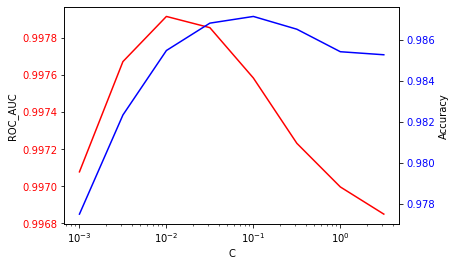

In [95]:
fig,ax=plt.subplots()
ax.plot(cv_results_df_svm_sk_fine['param_svm__C'],cv_results_df_svm_sk_fine['mean_test_roc_auc'],'r')
ax1=ax.twinx()
ax1.plot(cv_results_df_svm_sk_fine['param_svm__C'],cv_results_df_svm_sk_fine['mean_test_accuracy'],'b')
ax.set_ylabel('ROC_AUC')
ax1.set_ylabel('Accuracy')
ax.set_xlabel('C')
ax.tick_params(axis='y', labelcolor='r')
ax1.tick_params(axis='y', labelcolor='b')
ax.set_xscale('log')


>**In SVM model, the optimal parameter is chosen at `max_features=None` and L2 regulariztion with `C=0.1` because the variance of AUC of ROC is relatively small while the accuracy significantly peaks at `C=0.1`.**

In [96]:
best_auc_svm_sk,best_acc_svm_sk=cv_results_df_svm_sk_fine['mean_test_roc_auc'].iloc[4],cv_results_df_svm_sk_fine['mean_test_accuracy'].iloc[4]
print('Best esimate of ROC_AUC: {:.4f}'.format(best_auc_svm_sk))
print('Best esimate of accuracy: {:.4f}'.format(best_acc_svm_sk))

Best esimate of ROC_AUC: 0.9976
Best esimate of accuracy: 0.9871


# Summary: comparsion between naive Bayes and SVM 

In [97]:
summary=pd.DataFrame({'model':['Bayes from scratch','Bayes from MultinomialNB','SVM from LinearSVC'],'best_parameters':['max_features=None,smoothing=0.01', 'max_features=None,smoothing=0.01', 'max_features=None,kernel=linear,penalty=L2,C=0.1'],'best_ROC_AUC':[best_auc_bayes,best_auc_bayes_sk,best_auc_svm_sk],'best_accuracy':[best_acc_bayes,best_acc_bayes_sk,best_acc_svm_sk]}).set_index('model')

In [98]:
summary

best_parameters  \
model                                                                        
Bayes from scratch                        max_features=None,smoothing=0.01   
Bayes from MultinomialNB                  max_features=None,smoothing=0.01   
SVM from LinearSVC        max_features=None,kernel=linear,penalty=L2,C=0.1   

                          best_ROC_AUC  best_accuracy  
model                                                  
Bayes from scratch            0.997092       0.987276  
Bayes from MultinomialNB      0.996957       0.987276  
SVM from LinearSVC            0.997582       0.987128

In [99]:
print(summary.to_markdown(tablefmt='github'))

| model                    | best_parameters                                  |   best_ROC_AUC |   best_accuracy |
|--------------------------|--------------------------------------------------|----------------|-----------------|
| Bayes from scratch       | max_features=None,smoothing=0.01                 |       0.997092 |        0.987276 |
| Bayes from MultinomialNB | max_features=None,smoothing=0.01                 |       0.996957 |        0.987276 |
| SVM from LinearSVC       | max_features=None,kernel=linear,penalty=L2,C=0.1 |       0.997582 |        0.987128 |
